      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
mean       8.311111          0.531339     0.268364        2.532152   0.086933   
std        1.747595          0.179633     0.196686        1.355917   0.047267   
min        4.600000          0.120000     0.000000        0.900000   0.012000   
max       15.900000          1.580000     1.000000       15.500000   0.611000   

      free sulfur dioxide  total sulfur dioxide   density        pH  \
mean            15.615486             45.914698  0.996730  3.311015   
std             10.250486             32.782130  0.001925  0.156664   
min              1.000000              6.000000  0.990070  2.740000   
max             68.000000            289.000000  1.003690  4.010000   

      sulphates    alcohol   quality  
mean   0.657708  10.442111  5.657043  
std    0.170399   1.082196  0.805824  
min    0.330000   8.400000  3.000000  
max    2.000000  14.900000  8.000000  


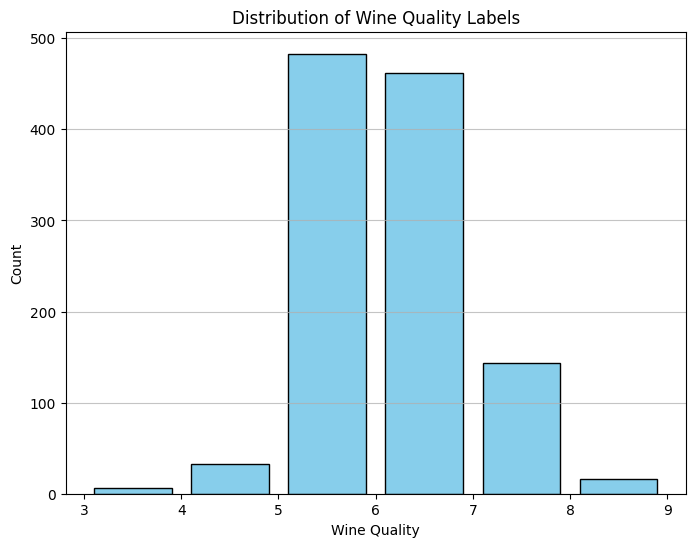

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

#-------Load the dataset and Print the statistics-------------
wine_data = pd.read_csv("WineQT.csv")
wine_data = wine_data.drop(columns=['Id'])
statistics = wine_data.agg(['mean', 'std', 'min', 'max'])
print(statistics)

#---a graph that shows the distribution of the various labels across the entire dataset----
wine_quality = wine_data['quality']

plt.figure(figsize=(8, 6))
plt.hist(wine_quality, bins=range(3, 10), rwidth=0.8, color='skyblue', edgecolor='black')
plt.xlabel('Wine Quality')
plt.ylabel('Count')
plt.title('Distribution of Wine Quality Labels')
plt.xticks(range(3, 10))
plt.grid(axis='y', alpha=0.75)
plt.show()

#---------Split the data into train (70%), validation (15%), and test (15%) sets--------
X = wine_data.drop(columns=['quality'])
y = wine_data['quality']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#-------------------Normalise and standarize the data------------------
# Handle missing data (if any)
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

# Standardize the data (mean=0, std=1) using Z-score scaling
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_val_standardized = scaler.transform(X_val)
X_test_standardized = scaler.transform(X_test)



In [2]:
import numpy as np
import wandb

class MLPClassifier:
    def __init__(self, num_hidden_layers=1, num_neurons=64, activation='relu', learning_rate=0.01, num_classes=6):
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons
        self.activation = activation
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.weights = []
        self.biases = []
        self.activations = [self.activation] * (num_hidden_layers + 1)
        self.activations[-1] = 'softmax'
    
    def initialize_weights_and_biases(self, input_dim):
        layer_sizes = [input_dim] + [self.num_neurons] * self.num_hidden_layers + [self.num_classes]
        for i in range(1, len(layer_sizes)):
            input_size, output_size = layer_sizes[i - 1], layer_sizes[i]
            weight = np.random.randn(input_size, output_size) * 0.01
            bias = np.zeros((1, output_size))
            self.weights.append(weight)
            self.biases.append(bias)

    def one_hot_encode(self, y):
        one_hot = np.zeros((len(y), self.num_classes))
        one_hot[np.arange(len(y)), y - 3] = 1
        return one_hot

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / exp_x.sum(axis=1, keepdims=True)

    def compute_loss(self, y_true, y_pred):
        m = len(y_true)
        loss = -1/m * np.sum(y_true * np.log(y_pred))
        return loss

    def activate(self, x, activation_type):
        if activation_type == 'relu':
            return np.maximum(0, x)
        elif activation_type == 'sigmoid':
            x = np.clip(x, -500, 500)
            return 1 / (1 + np.exp(-x))
        elif activation_type == 'tanh':
            return np.tanh(x)
        elif activation_type == 'softmax':
            return self.softmax(x)

    def d_relu(self, x):
        return np.where(x > 0, 1, 0)

    def d_sigmoid(self, x):
        return x * (1 - x)

    def d_tanh(self, x):
        return 1 - np.tanh(x) ** 2

    def forward_propagation(self, x):
        z_values = []
        a_values = [x]
        for i in range(self.num_hidden_layers):
            z = np.dot(a_values[i], self.weights[i]) + self.biases[i]
            a = self.activate(z, self.activations[i])
            z_values.append(z)
            a_values.append(a)
        
        # Output layer with softmax activation
        z = np.dot(a_values[-1], self.weights[-1]) + self.biases[-1]
        a = self.activate(z, self.activations[-1])
        z_values.append(z)
        a_values.append(a)
        
        return z_values, a_values

    def backward_propagation(self, x, y):
        m = x.shape[0]
        z_values, a_values = self.forward_propagation(x)
        gradients = [None] * (self.num_hidden_layers + 1)
        
        # Compute gradient of the output layer
        gradients[-1] = a_values[-1] - y
        
        # Backpropagate through hidden layers
        for i in reversed(range(self.num_hidden_layers)):
            if self.activations[i] == 'relu':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_relu(a_values[i + 1])
            elif self.activations[i] == 'sigmoid':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_sigmoid(a_values[i + 1])
            elif self.activations[i] == 'tanh':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_tanh(a_values[i + 1])
        
        # Compute gradients for weights and biases
        dW = [None] * (self.num_hidden_layers + 1)
        db = [None] * (self.num_hidden_layers + 1)
        for i in range(self.num_hidden_layers + 1):
            dW[i] = np.dot(a_values[i].T, gradients[i]) / m
            db[i] = np.sum(gradients[i], axis=0) / m
        
        return dW, db

    def predict(self, x):
        _, y_pred = self.forward_propagation(x)
        shifted_y_pred = np.argmax(y_pred[-1], axis=1) + 3
        return shifted_y_pred
    
    def sgd(self, x, y, num_epochs=1000):
        input_dim = x.shape[1]
        self.initialize_weights_and_biases(input_dim)
        y_encoded = self.one_hot_encode(y)

        m = x.shape[0]  # Number of training samples

        for epoch in range(num_epochs):
            for i in range(m):
                # Select a random training sample (Stochastic Gradient Descent)
                random_index = np.random.randint(0, m)
                x_sample = x[random_index:random_index + 1]
                y_sample = y_encoded[random_index:random_index + 1]

                dW, db = self.backward_propagation(x_sample, y_sample)

                for j in range(self.num_hidden_layers + 1):
                    self.weights[j] -= self.learning_rate * dW[j]
                    self.biases[j] -= self.learning_rate * db[j]

                _, y_pred = self.forward_propagation(x)
                loss = self.compute_loss(y_encoded, y_pred[-1])
                wandb.log({f"Loss Optimizer=SGD Epochs={num_epochs} Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": loss})
                self.evaluate_model(x,y)
                
            if (epoch + 1) % 100 == 0:
                print(f"SGD Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")

        print("SGD Training complete!")


    def batch_gradient_descent(self, x, y, batch_size=32, num_epochs=1000):
        input_dim = x.shape[1]
        self.initialize_weights_and_biases(input_dim)
        y_encoded = self.one_hot_encode(y)
        
        m = x.shape[0]  # Number of training samples
        
        for epoch in range(num_epochs):
            for i in range(0, m, batch_size):
                x_batch = x[i:i+batch_size]
                y_batch = y_encoded[i:i+batch_size]
                
                dW, db = self.backward_propagation(x_batch, y_batch)
                
                for j in range(self.num_hidden_layers + 1):
                    self.weights[j] -= self.learning_rate * dW[j]
                    self.biases[j] -= self.learning_rate * db[j]
            
            _, y_pred = self.forward_propagation(x)
            loss = self.compute_loss(y_encoded, y_pred[-1])
            wandb.log({f"Loss Optimizer=Batch Epochs={num_epochs} Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": loss})
            self.evaluate_model(x,y)
            
            if (epoch + 1) % 100 == 0:
                print(f"Batch Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")
        
        print("Batch Training complete!")

    def mini_batch_gradient_descent(self, x, y, batch_size=32, num_epochs=1000):
        input_dim = x.shape[1]
        self.initialize_weights_and_biases(input_dim)
        y_encoded = self.one_hot_encode(y)
        
        m = x.shape[0]  # Number of training samples
        
        for epoch in range(num_epochs):
            indices = np.arange(m)
            np.random.shuffle(indices)
            x_shuffled = x[indices]
            y_shuffled = y_encoded[indices]
            
            for i in range(0, m, batch_size):
                x_batch = x_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                dW, db = self.backward_propagation(x_batch, y_batch)
                
                for j in range(self.num_hidden_layers + 1):
                    self.weights[j] -= self.learning_rate * dW[j]
                    self.biases[j] -= self.learning_rate * db[j]
            
            _, y_pred = self.forward_propagation(x)
            loss = self.compute_loss(y_encoded, y_pred[-1])
            wandb.log({f"Loss Optimizer=Mini_Batch Epochs={num_epochs} Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": loss})
            self.evaluate_model(x,y)
            
            if (epoch + 1) % 100 == 0:
                print(f"Mini_Batch Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")
        
        print("Mini_Batch Training complete!")
    
    def evaluate_model(self,x, y,isTrain=True):
        _, y_pred = self.forward_propagation(x)
        shifted_y_pred = np.argmax(y_pred[-1], axis=1) + 3
        accuracy = np.mean(shifted_y_pred == y)
        if isTrain == True:
            wandb.log({f"Train_accuracy Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": accuracy})
        else:
            wandb.log({f"Validation_accuracy Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": accuracy})



wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Loss Optimizer=SGD Epochs=500 Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=64 Activation=relu,█▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_accuracy Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=64 Activation=relu,▁▁▄▆▆▆▇▆▇▇▇▆▇▇▆▇▇▇▇▇█▇█▇▇███████████████
Loss Optimizer=SGD Epochs=500 Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=64 Activation=relu,0.87221
Train_accuracy Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=64 Activation=relu,0.6425


SGD Epoch 100/100, Loss: 0.9661
SGD Training complete!


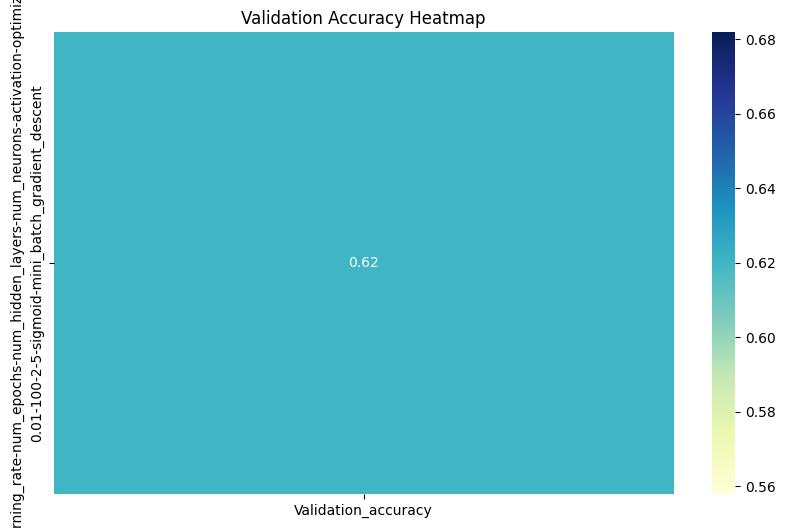

Hyperparameters for the Best Model:
learning_rate: 0.01
num_epochs: 100
num_hidden_layers: 2
num_neurons: 5
activation: sigmoid
optimizer: mini_batch_gradient_descent
+---------------+------------------+-------------------------+-------------------+---------------------+-----------------------------+--------------------+--------------------+--------------------+--------------------+
| Learning Rate | Number of Epochs | Number of Hidden Layers | Number of Neurons | Activation Function |          Optimizer          |      Accuracy      |      F1 Score      |     Precision      |       Recall       |
+---------------+------------------+-------------------------+-------------------+---------------------+-----------------------------+--------------------+--------------------+--------------------+--------------------+
|      0.01     |       100        |            2            |         5         |       sigmoid       | mini_batch_gradient_descent | 0.6198830409356725 | 0.5645029312114878 |

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Loss Optimizer=SGD Epochs=100 Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,███████████▇▇▇▆▅▄▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁
Train_accuracy Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,▂▁▁▂▁▂▂▂▂▁▂▂▁▂▅▆▇▆▇▇▇▇█▇█▇▇█▇▇▇█▇█▇█▇▇██
Validation_accuracy Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,▁
Loss Optimizer=SGD Epochs=100 Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,0.96609
Train_accuracy Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,0.6025
Validation_accuracy Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,0.61988


In [4]:
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable
from sklearn.metrics import classification_report

wandb.init(project='q2_1',entity='ashishchokhani2910')
best_accuracy = 0
best_model = None
best_hyperparameters = None

# Define hyperparameters to tune
learning_rates = [0.01, 0.001]
num_epochs = [500, 1000]
num_hidden_layers = [1, 2]
num_neurons = [64, 128]
activations = ['relu', 'sigmoid','tanh']
optimizers = ['sgd', 'batch_gradient_descent', 'mini_batch_gradient_descent']

# # Define hyperparameters to tune
# learning_rates = [0.01]
# num_epochs = [100]
# num_hidden_layers = [2]
# num_neurons = [5]
# activations = ['sigmoid']
# optimizers = ['mini_batch_gradient_descent']

metrics_table = PrettyTable()
metrics_table.field_names = ["Learning Rate", "Number of Epochs", "Number of Hidden Layers", "Number of Neurons", "Activation Function", "Optimizer", "Accuracy", "F1 Score", "Precision", "Recall"]


# Initialize a dictionary to collect metrics and hyperparameters
hyperparameter_metrics = {
    'learning_rate': [],
    'num_epochs': [],
    'num_hidden_layers': [],
    'num_neurons': [],
    'activation': [],
    'optimizer': [],
    'Validation_accuracy': [],
}

# Perform hyperparameter tuning
for lr, epochs, num_layers, num_neurons, activation, optimizer in product(learning_rates, num_epochs, num_hidden_layers, num_neurons, activations, optimizers):
    
    config = {
        'learning_rate': lr,
        'num_epochs': epochs,
        'num_hidden_layers': num_layers,
        'num_neurons': num_neurons,
        'activation': activation,
        'optimizer': optimizer
    }
    wandb.config.update(config)

    model = MLPClassifier(
        num_hidden_layers=num_layers,
        num_neurons=num_neurons,
        activation=activation,
        learning_rate=lr
    )
    model.sgd(X_train_standardized, y_train, num_epochs=epochs)
    model.evaluate_model(X_val_standardized,y_val,isTrain=False)
    y_pred_val = model.predict(X_val_standardized)
    
    #Calculate and report metrics
    accuracy = accuracy_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val, average='weighted', zero_division=1) 
    precision = precision_score(y_val, y_pred_val, average='weighted', zero_division=1)
    recall = recall_score(y_val, y_pred_val, average='weighted', zero_division=1)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_hyperparameters = {
            'learning_rate': lr,
            'num_epochs': epochs,
            'num_hidden_layers': num_layers,
            'num_neurons': num_neurons,
            'activation': activation,
            'optimizer': optimizer
        }
        
    metrics_table.add_row([lr, epochs, num_layers, num_neurons, activation, optimizer, accuracy, f1, precision, recall])
    
    hyperparameter_metrics['learning_rate'].append(lr)
    hyperparameter_metrics['num_epochs'].append(epochs)
    hyperparameter_metrics['num_hidden_layers'].append(num_layers)
    hyperparameter_metrics['num_neurons'].append(num_neurons)
    hyperparameter_metrics['activation'].append(activation)
    hyperparameter_metrics['optimizer'].append(optimizer)
    hyperparameter_metrics['Validation_accuracy'].append(accuracy)

df = pd.DataFrame(hyperparameter_metrics)
hyperparameters = ['learning_rate', 'num_epochs', 'num_hidden_layers', 'num_neurons', 'activation', 'optimizer']

# Create a pivot table for the heatmap
pivot_table = df.pivot_table(index=hyperparameters, values='Validation_accuracy', aggfunc='mean')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Validation Accuracy Heatmap')
plt.show()


print("Hyperparameters for the Best Model:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

print(metrics_table)

y_pred_test = best_model.predict(X_test_standardized)
unique_labels = sorted(set(y_test))
target_names = [str(label) for label in unique_labels]

report = classification_report(y_test, y_pred_test, target_names=target_names,zero_division=1)
print("Classification Report on Test Set:")
print(report)

# Finish the W&B run
wandb.run.finish()


## W&B report for above hyperparameters

https://wandb.ai/ashishchokhani2910/q2_1/reports/MLP-Classifier--Vmlldzo1NzU2Njk0

## Compare the results with the results of the logistic regression model with MLP

# Model Complexity:

- MLR is a linear model that assumes a linear relationship between input features and the log-odds of different classes. It's simple and interpretable but may not capture complex, nonlinear relationships.
- MLP, on the other hand, is a neural network model that can capture complex nonlinear patterns in the data. It is inherently more flexible and can model intricate relationships.
Feature Engineering:

- MLR typically requires feature engineering to ensure that the input features are linearly separable. This can involve transformations or interactions between features.
MLPs can automatically learn relevant features from the data, which can be an advantage when dealing with high-dimensional or unstructured data.
Performance:

# Interpretability:

- MLR models are highly interpretable. We can easily understand the impact of each feature on the predicted class probabilities.
- MLPs are less interpretable due to their complex, layered architecture. Understanding feature importance in an MLP is more challenging.
# Overfitting:

- MLR models are less prone to overfitting, especially when we have a small dataset or a limited number of features.
- MLPs, with their greater complexity, can be more prone to overfitting. Regularization techniques and careful architecture design are often necessary to mitigate this risk.

In [6]:
import numpy as np
import wandb

class MLPClassifierMultilabel:
    def __init__(self, num_hidden_layers=1, num_neurons=64, activation='relu', learning_rate=0.01, num_classes=6):
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons
        self.activation = activation
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.weights = []
        self.biases = []
        self.activations = [self.activation] * (num_hidden_layers + 1)
        self.activations[-1] = 'sigmoid' 

    def initialize_weights_and_biases(self, input_dim):
        layer_sizes = [input_dim] + [self.num_neurons] * self.num_hidden_layers + [self.num_classes]
        for i in range(1, len(layer_sizes)):
            input_size, output_size = layer_sizes[i - 1], layer_sizes[i]
            weight = np.random.randn(input_size, output_size) * 0.01
            bias = np.zeros((1, output_size))
            self.weights.append(weight)
            self.biases.append(bias)

    def compute_loss(self, y_true, y_pred):
        m = len(y_true)
        loss = -1/m * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss

    def activate(self, x, activation_type):
        if activation_type == 'relu':
            return np.maximum(0, x)
        elif activation_type == 'sigmoid':
            x = np.clip(x, -500, 500)
            return 1 / (1 + np.exp(-x))
        elif activation_type == 'tanh':
            return np.tanh(x)

    def d_relu(self, x):
        return np.where(x > 0, 1, 0)

    def d_sigmoid(self, x):
        return x * (1 - x)

    def d_tanh(self, x):
        return 1 - np.tanh(x) ** 2

    def forward_propagation(self, x):
        z_values = []
        a_values = [x]
        for i in range(self.num_hidden_layers):
            z = np.dot(a_values[i], self.weights[i]) + self.biases[i]
            a = self.activate(z, self.activations[i])
            z_values.append(z)
            a_values.append(a)

        # Output layer with sigmoid activation for multilabel classification
        z = np.dot(a_values[-1], self.weights[-1]) + self.biases[-1]
        a = self.activate(z, self.activations[-1])
        z_values.append(z)
        a_values.append(a)

        return z_values, a_values

    def backward_propagation(self, x, y):
        m = x.shape[0]
        z_values, a_values = self.forward_propagation(x)
        gradients = [None] * (self.num_hidden_layers + 1)

        # Compute gradient of the output layer
        gradients[-1] = a_values[-1] - y

        # Backpropagate through hidden layers
        for i in reversed(range(self.num_hidden_layers)):
            if self.activations[i] == 'relu':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_relu(a_values[i + 1])
            elif self.activations[i] == 'sigmoid':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_sigmoid(a_values[i + 1])
            elif self.activations[i] == 'tanh':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_tanh(a_values[i + 1])

        # Compute gradients for weights and biases
        dW = [None] * (self.num_hidden_layers + 1)
        db = [None] * (self.num_hidden_layers + 1)
        for i in range(self.num_hidden_layers + 1):
            dW[i] = np.dot(a_values[i].T, gradients[i]) / m
            db[i] = np.sum(gradients[i], axis=0) / m

        return dW, db

    def predict(self, x, threshold=0.5):
        _, y_pred = self.forward_propagation(x)
        shifted_y_pred = (y_pred[-1] > threshold).astype(int)
        return shifted_y_pred

    def sgd(self, x, y, num_epochs=1000):
        input_dim = x.shape[1]
        self.initialize_weights_and_biases(input_dim)

        m = x.shape[0]  # Number of training samples

        for epoch in range(num_epochs):
            for i in range(m):
                # Select a random training sample (Stochastic Gradient Descent)
                random_index = np.random.randint(0, m)
                x_sample = x[random_index:random_index + 1]
                y_sample = y[random_index:random_index + 1]

                dW, db = self.backward_propagation(x_sample, y_sample)

                for j in range(self.num_hidden_layers + 1):
                    self.weights[j] -= self.learning_rate * dW[j]
                    self.biases[j] -= self.learning_rate * db[j]

                _, y_pred = self.forward_propagation(x)
                loss = self.compute_loss(y, y_pred[-1])
                wandb.log({f"Loss Optimizer=SGD Epochs={num_epochs} Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": loss})
                self.evaluate_model(x, y)

            if (epoch + 1) % 100 == 0:
                print(f"SGD Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")

        print("SGD Training complete!")
        
    def batch_gradient_descent(self, x, y, batch_size=32, num_epochs=1000):
        input_dim = x.shape[1]
        self.initialize_weights_and_biases(input_dim)
        
        m = x.shape[0]  # Number of training samples
        
        for epoch in range(num_epochs):
            for i in range(0, m, batch_size):
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                
                dW, db = self.backward_propagation(x_batch, y_batch)
                
                for j in range(self.num_hidden_layers + 1):
                    self.weights[j] -= self.learning_rate * dW[j]
                    self.biases[j] -= self.learning_rate * db[j]
            
            _, y_pred = self.forward_propagation(x)
            loss = self.compute_loss(y, y_pred[-1])
            wandb.log({f"Loss Optimizer=Batch Epochs={num_epochs} Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": loss})
            self.evaluate_model(x,y)
            
            if (epoch + 1) % 100 == 0:
                print(f"Batch Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")
        
        print("Batch Training complete!")

    def mini_batch_gradient_descent(self, x, y, batch_size=32, num_epochs=1000):
        input_dim = x.shape[1]
        self.initialize_weights_and_biases(input_dim)
        
        m = x.shape[0]  # Number of training samples
        
        for epoch in range(num_epochs):
            indices = np.arange(m)
            np.random.shuffle(indices)
            x_shuffled = x[indices]
            y_shuffled = y[indices]
            
            for i in range(0, m, batch_size):
                x_batch = x_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                dW, db = self.backward_propagation(x_batch, y_batch)
                
                for j in range(self.num_hidden_layers + 1):
                    self.weights[j] -= self.learning_rate * dW[j]
                    self.biases[j] -= self.learning_rate * db[j]
            
            _, y_pred = self.forward_propagation(x)
            loss = self.compute_loss(y, y_pred[-1])
            wandb.log({f"Loss Optimizer=Mini_Batch Epochs={num_epochs} Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": loss})
            self.evaluate_model(x,y)
            
            if (epoch + 1) % 100 == 0:
                print(f"Mini_Batch Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")
        
        print("Mini_Batch Training complete!")

    def evaluate_model(self, x, y, isTrain=True):
        _, y_pred = self.forward_propagation(x)
        shifted_y_pred = (y_pred[-1] > 0.5).astype(int)
        accuracy = np.mean(np.all(shifted_y_pred == y, axis=1))
        if isTrain:
            wandb.log({f"Train_accuracy Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": accuracy})
        else:
            wandb.log({f"Validation_accuracy Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": accuracy})

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


SGD Epoch 100/1000, Loss: 4.9750
SGD Epoch 200/1000, Loss: 4.8225
SGD Epoch 300/1000, Loss: 4.4169
SGD Epoch 400/1000, Loss: 4.2133
SGD Epoch 500/1000, Loss: 4.1176
SGD Epoch 600/1000, Loss: 4.0819
SGD Epoch 700/1000, Loss: 4.0372
SGD Epoch 800/1000, Loss: 4.0225
SGD Epoch 900/1000, Loss: 4.0134
SGD Epoch 1000/1000, Loss: 4.0047
SGD Training complete!


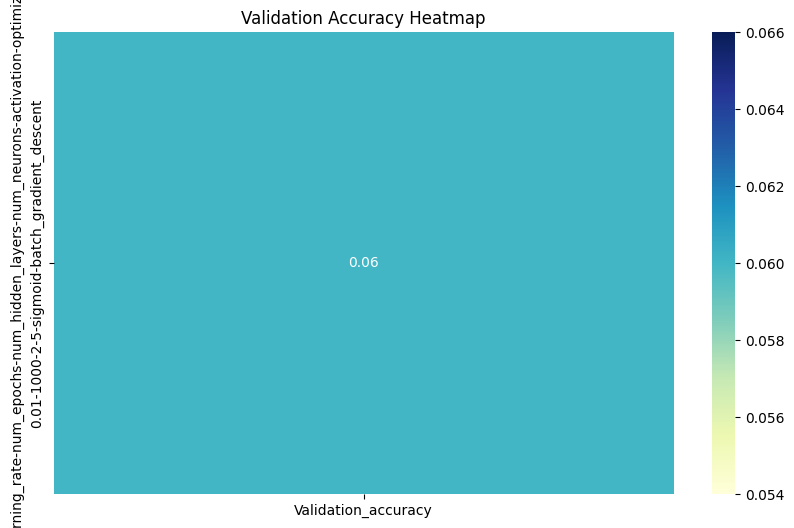

Hyperparameters for the Best Model:
learning_rate: 0.01
num_epochs: 1000
num_hidden_layers: 2
num_neurons: 5
activation: sigmoid
optimizer: batch_gradient_descent
+---------------+------------------+-------------------------+-------------------+---------------------+------------------------+----------+--------------------+--------------------+--------------------+
| Learning Rate | Number of Epochs | Number of Hidden Layers | Number of Neurons | Activation Function |       Optimizer        | Accuracy |      F1 Score      |     Precision      |       Recall       |
+---------------+------------------+-------------------------+-------------------+---------------------+------------------------+----------+--------------------+--------------------+--------------------+
|      0.01     |       1000       |            2            |         5         |       sigmoid       | batch_gradient_descent |   0.06   | 0.4647737941451349 | 0.5420410053533175 | 0.4166666666666667 |
+---------------+----

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Loss Optimizer=SGD Epochs=1000 Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,███▇▇▇▆▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_accuracy Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,▁▁▁▂▂▃▂▂▂▄▄▅▅▆▇▇▇▇▇▇▇▇▇██▇▇█▇▇▇▇▇▇▇▇▇▇▇█
Validation_accuracy Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,▁
Loss Optimizer=SGD Epochs=1000 Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,4.00469
Train_accuracy Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,0.12
Validation_accuracy Learning Rate=0.01 Num_hidden_layers=2 Num_neurons=5 Activation=sigmoid,0.06


In [7]:
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

df = pd.read_csv('advertisement.csv')
df = df.drop('city', axis=1)
X = pd.get_dummies(df.drop('labels', axis=1), columns=['gender','education','married','occupation','most bought item'])
X=np.array(X)
X=X.astype(float)
y = df['labels']

# Process the labels into a suitable format for multilabel classification
y = y.str.split()  # Split labels into lists of labels
unique_labels = set(label for labels in y for label in labels)
label_to_index = {label: i for i, label in enumerate(unique_labels)}

# Map labels to binary format
y_binary = np.zeros((len(y), len(unique_labels)), dtype=int)
for i, labels in enumerate(y):
    for label in labels:
        y_binary[i, label_to_index[label]] = 1
        

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_binary, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_val_standardized = scaler.transform(X_val)
X_test_standardized = scaler.transform(X_test)

# Initialize and train the model
wandb.init(project='q2_4',entity='ashishchokhani2910')
best_accuracy = 0
best_model = None
best_hyperparameters = None

# Define hyperparameters to tune
learning_rates = [0.01, 0.001]
num_epochs = [500, 1000]
num_hidden_layers = [1, 2]
num_neurons = [64, 128]
activations = ['relu', 'sigmoid','tanh']
optimizers = ['sgd', 'batch_gradient_descent', 'mini_batch_gradient_descent']

# # Define hyperparameters to tune
# learning_rates = [0.01]
# num_epochs = [1000]
# num_hidden_layers = [2]
# num_neurons = [5]
# activations = ['sigmoid']
# optimizers = ['batch_gradient_descent']

metrics_table = PrettyTable()
metrics_table.field_names = ["Learning Rate", "Number of Epochs", "Number of Hidden Layers", "Number of Neurons", "Activation Function", "Optimizer", "Accuracy", "F1 Score", "Precision", "Recall"]

# Initialize a dictionary to collect metrics and hyperparameters
hyperparameter_metrics = {
    'learning_rate': [],
    'num_epochs': [],
    'num_hidden_layers': [],
    'num_neurons': [],
    'activation': [],
    'optimizer': [],
    'Validation_accuracy': [],
}

# Perform hyperparameter tuning
for lr, epochs, num_layers, num_neurons, activation, optimizer in product(learning_rates, num_epochs, num_hidden_layers, num_neurons, activations, optimizers):
    
    config = {
        'learning_rate': lr,
        'num_epochs': epochs,
        'num_hidden_layers': num_layers,
        'num_neurons': num_neurons,
        'activation': activation,
        'optimizer': optimizer
    }
    wandb.config.update(config)

    model = MLPClassifierMultilabel(
        num_hidden_layers=num_layers,
        num_neurons=num_neurons,
        activation=activation,
        learning_rate=lr,
        num_classes=len(unique_labels)
    )
    model.sgd(X_train_standardized, y_train, num_epochs=epochs)
    model.evaluate_model(X_val_standardized,y_val,isTrain=False)
    y_pred_val = model.predict(X_val_standardized)
    
    #Calculate and report metrics
    accuracy = accuracy_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val, average='weighted', zero_division=1) 
    precision = precision_score(y_val, y_pred_val, average='weighted', zero_division=1)
    recall = recall_score(y_val, y_pred_val, average='weighted', zero_division=1)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_hyperparameters = {
            'learning_rate': lr,
            'num_epochs': epochs,
            'num_hidden_layers': num_layers,
            'num_neurons': num_neurons,
            'activation': activation,
            'optimizer': optimizer
        }
        
    metrics_table.add_row([lr, epochs, num_layers, num_neurons, activation, optimizer, accuracy, f1, precision, recall])
    
    hyperparameter_metrics['learning_rate'].append(lr)
    hyperparameter_metrics['num_epochs'].append(epochs)
    hyperparameter_metrics['num_hidden_layers'].append(num_layers)
    hyperparameter_metrics['num_neurons'].append(num_neurons)
    hyperparameter_metrics['activation'].append(activation)
    hyperparameter_metrics['optimizer'].append(optimizer)
    hyperparameter_metrics['Validation_accuracy'].append(accuracy)

df = pd.DataFrame(hyperparameter_metrics)
hyperparameters = ['learning_rate', 'num_epochs', 'num_hidden_layers', 'num_neurons', 'activation', 'optimizer']

# Create a pivot table for the heatmap
pivot_table = df.pivot_table(index=hyperparameters, values='Validation_accuracy', aggfunc='mean')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Validation Accuracy Heatmap')
plt.show()

print("Hyperparameters for the Best Model:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

print(metrics_table)

y_pred_test = best_model.predict(X_test_standardized)
report = classification_report(y_test, y_pred_test,zero_division=1)
print("Classification Report on Test Set:")
print(report)

# Finish the W&B run
wandb.run.finish()


## W&B report for above hyperparameters

https://wandb.ai/ashishchokhani2910/q2_4/reports/Multi-Label-Classsification--Vmlldzo1NzU2NzY2